Goal: evaluate performance on different initial conditions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
from train import *
from model import lmmNet
from predict import *

In [14]:
# specify the settings for the bier data

t0, T, h = 0, 500, 0.2 #seconds
x0 = np.array([4, 3]) #initial conditions: ATP = 4, G = 3 -- default Bier model for training
ic1 = np.array([2, 1]) #initial conditions: ATP = 2, G = 1 -- initial conditions for testing
params = {'Vin': 0.36, 'k1': 0.02, 'kp':4, 'km':15} # damped oscillation
f_bier = lambda x, t: bier(x, t, params)

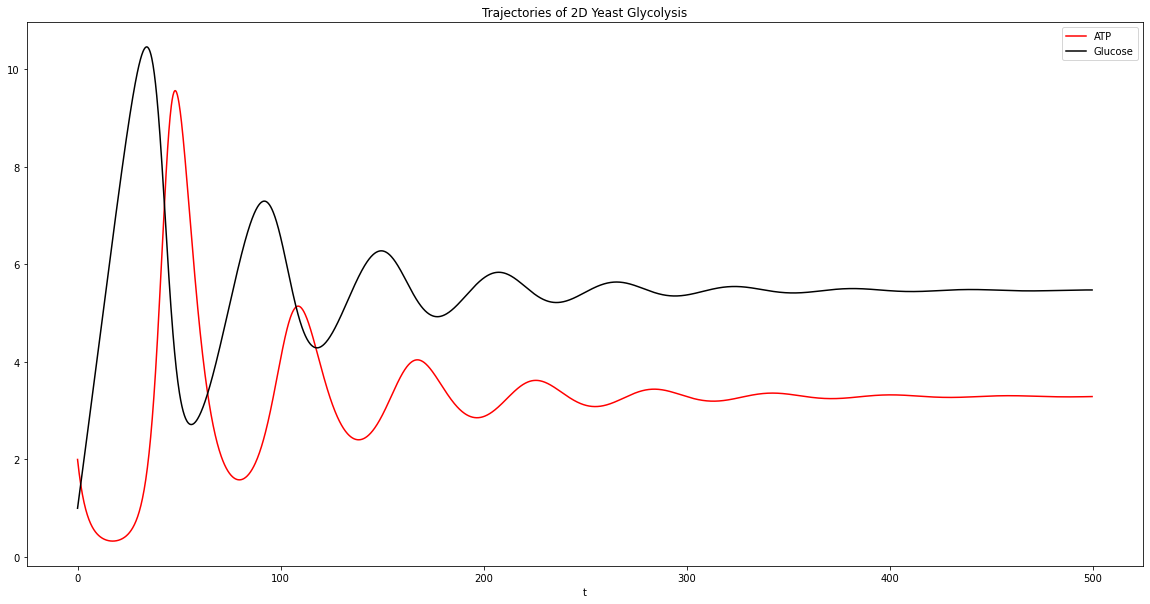

In [9]:
# visually inspect the test data

time_points, data = create_training_data(t0, T, h, f_bier, ic1)

plt.figure(figsize=(20, 10))
plt.plot(time_points, data[0,:, 0], 'r-', label='ATP')
plt.plot(time_points, data[0,:,1], 'k-', label='Glucose')
plt.xlabel('t')
plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

In [11]:
# parameters for multistep NN

hidden_layer_units = 256 # number of units for the hidden layer
M = 1 # number of steps
scheme = 'AM' # LMM scheme

time_points, data = create_training_data(t0, T, h, f_bier, x0)
data.shape

TensorShape([1, 2500, 2])

In [ ]:
# test if it works for 5 epochs
net = lmmNet(h, data, M, scheme, hidden_layer_units)
N_Iter = 10000
net.train(N_Iter)

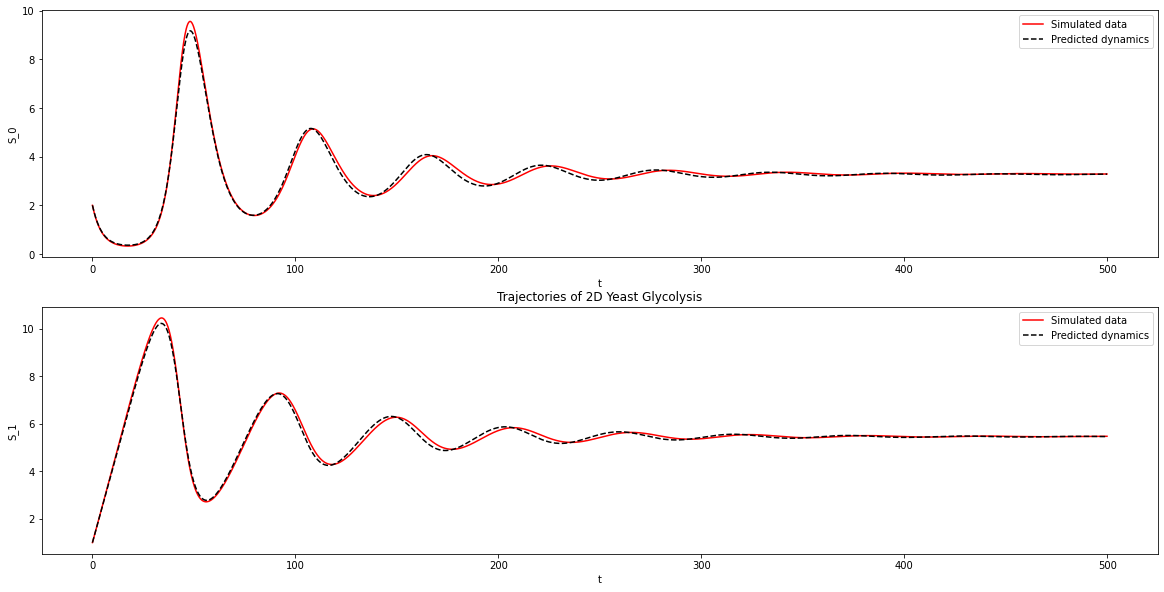

In [15]:
pred = odeint(predict_fn, ic1, time_points, args=(net,))

plt.figure(figsize=(20, 10))
for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, data[0,:, species], 'r-', label='Simulated data')
    plt.plot(time_points, pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

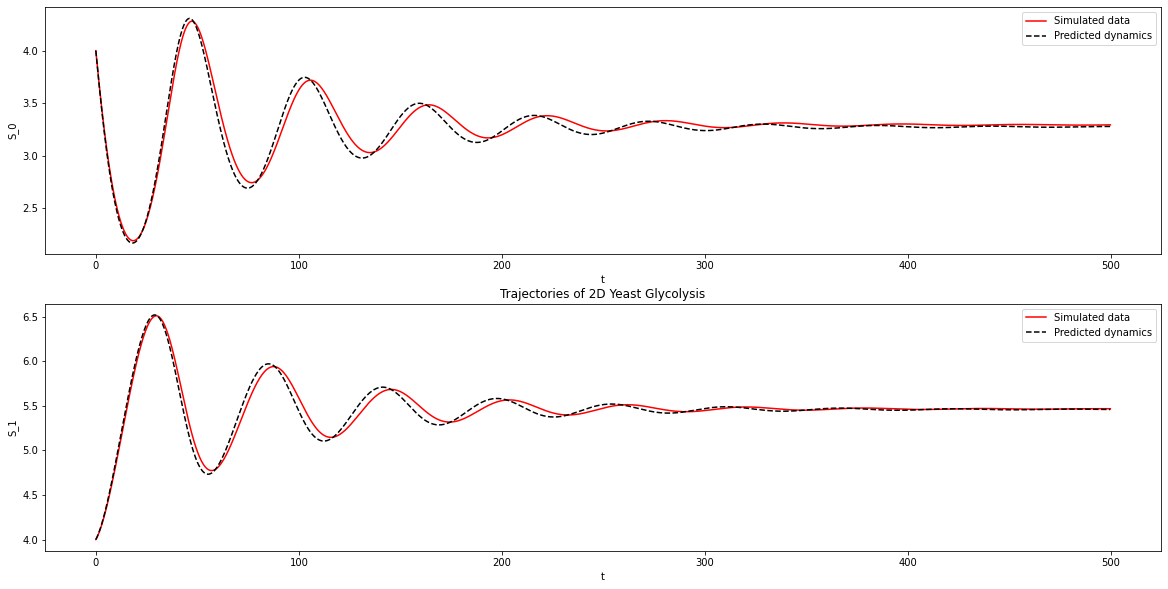

In [16]:
# validate on more test data
ic1 = np.array([4,4])
pred = odeint(predict_fn, ic1, time_points, args=(net,))
time_points, data = create_training_data(t0, T, h, f_bier, ic1)

plt.figure(figsize=(20, 10))
for species in range(2):
    plt.subplot(2,1,species + 1)
    plt.plot(time_points, data[0,:, species], 'r-', label='Simulated data')
    plt.plot(time_points, pred[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 2D Yeast Glycolysis')
plt.show()

# Discovering Bifurcation

A major test for the multistep neural network is to also discover bifurcation from the data. To do this, the 2-D system can be rewritten in a 3-D system of equations with the parameter space as the extra dimension.

Text(0.5, 1.0, 'Phase plane of 2D Yeast Glycolytic Oscillator')

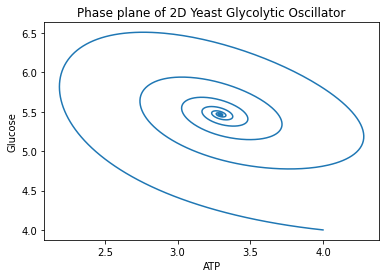

In [20]:
plt.plot(data[0, :,0], data[0, :,1], label='simulated_data')
plt.xlabel('ATP')
plt.ylabel('Glucose')
plt.title('Phase plane of 2D Yeast Glycolytic Oscillator')

Text(0.5, 1.0, 'Phase plane of 2D Yeast Glycolytic Oscillator')

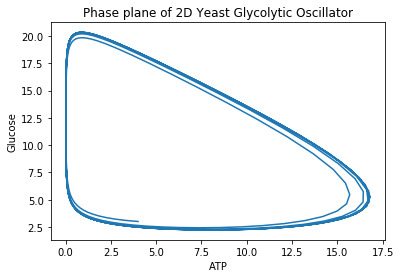

In [21]:
# specify the settings for the bier data

t0, T, h = 0, 500, 0.7 #seconds
x0 = np.array([4, 3]) #initial conditions: ATP = 4, G = 3 -- default Bier model for training
f_bier = lambda x, t: bier(x, t)
time_points, o_data = create_training_data(t0, T, h, f_bier, x0)
plt.plot(o_data[0, :,0], o_data[0, :,1], label='simulated_data')
plt.xlabel('ATP')
plt.ylabel('Glucose')
plt.title('Phase plane of 2D Yeast Glycolytic Oscillator')

In [22]:
def bier3D(x,t, params=None):
    """
    2-D Yeast Glycolytic oscillator model with an extra parameter dimension
    
    Args:
        x -- a 3 x 1 vector of measurements
        t -- time, ignored
        
    Return:
        A numpy array containing the derivatives
    """
    if params == None:
        # default parameter values
        #Vin = 0.36
        k1 = 0.02
        kp = 6
        km = 12
    else:
        #Vin = params['Vin']
        k1 = params['k1']
        kp = params['kp']
        km = params['km']
    
    Vin = x[0] # constant
    
    r0 = 0
    r1 = 2 * k1 * x[1] * x[2] - kp * x[1]/(x[1] + km) # ATP
    r2 = Vin - k1 * x[1] * x[2] #G
    
    return np.ravel(np.array([r0, r1, r2]))

Next we would like to train on the different initial conditions, represented as different trajectories of the dynamical system.

In [35]:
# specify the settings for the bier data

x0 = np.array([[0.4, 4, 3],
               [1.1, 4, 3],
               [0.8, 4,3],
               [0.9, 4, 3],
               [1.0, 4, 3],
               [1.2, 4, 3],
               [1.0, 4, 3],
               [0.8, 4, 3],
               [0.7, 4, 3],
               [1.2, 4, 3]])

f_bier3D = lambda x, t: bier3D(x, t)

In [36]:
S = x0.shape[0] # number of trajectories
N = time_points.shape[0] # number of time points (i.e. the grid size)
D = x0.shape[1] # number of dimensions/species
noise_strength = 0

hopf_data = np.zeros((S, N, D))
for k in range(0, S):
    hopf_data[k,:,:] = odeint(f_bier3D, x0[k,:], time_points)

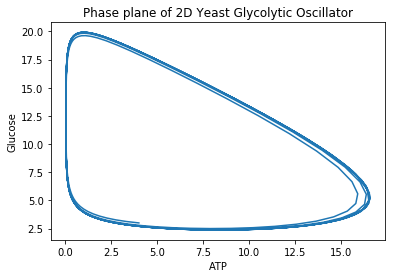

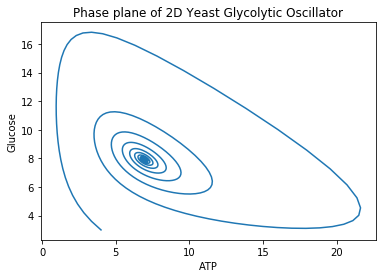

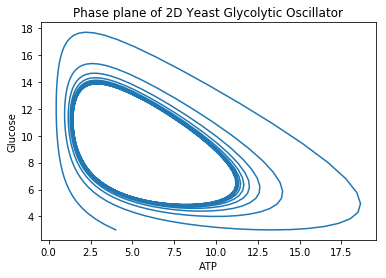

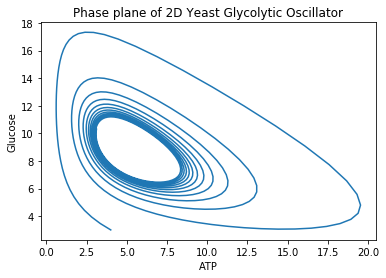

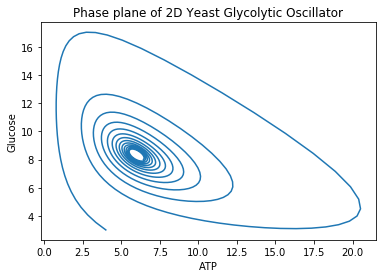

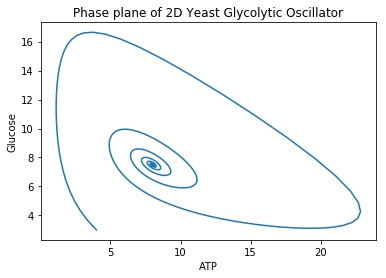

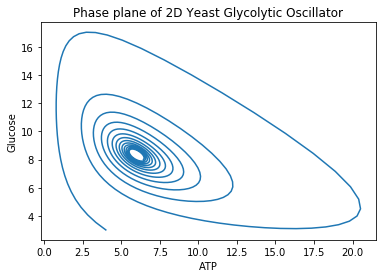

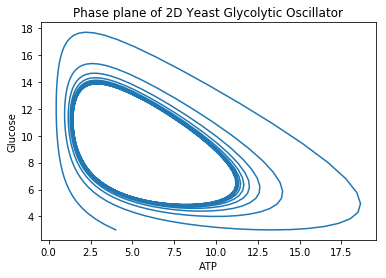

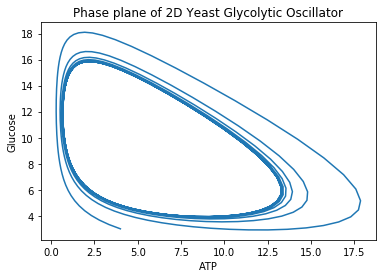

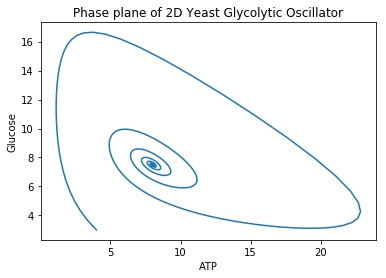

In [37]:
for i in range(len(x0)):
    plt.plot(hopf_data[i, :,1], hopf_data[i, :,2], label='simulated_data')
    plt.xlabel('ATP')
    plt.ylabel('Glucose')
    plt.title('Phase plane of 2D Yeast Glycolytic Oscillator')
    plt.show()

In [38]:
hidden_layer_units = 256 # number of units for the hidden layer
M = 1 # number of steps
scheme = 'AM' # LMM scheme
net1 = lmmNet(0.7, hopf_data, M, scheme, hidden_layer_units)

N_Iter = 3000
net1.train(N_Iter)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [58]:
# inference

y0 = np.array([[0.6,2,1],
                   #[0.1,2,1],

                   #[0.2,4,3],
                   #[0.3,4,3],
                   [0.54,4,3],
                   #[0.35,4,3],
                   [.45,4,3],
                   [.55,4,3],

                   [1.55,4,3],

                   [1.45,4,3],
                   #[1.65,2,1],
                   #[1.60,2,3],
                   #[1.55,2,3],
                   #[1.70,2,3],
                   #[1.55,2,3],

                   #[0.2,2,3],
                   ])
    
    
hopf_pred = np.zeros((y0.shape[0], time_points.shape[0], y0.shape[1]))

for k in range(0, y0.shape[0]):
    hopf_pred[k,:] = odeint(predict_fn, y0[k,:], time_points, args=(net1,))

In [57]:
hopf_pred[12,:]

array([[ 0.1       ,  2.        ,  3.        ],
       [ 0.10242743,  1.60472677,  2.98789061],
       [ 0.1051645 ,  1.27050936,  2.99803167],
       ...,
       [-0.02628993, -0.15075466,  3.85022941],
       [-0.02628135, -0.15076821,  3.85019578],
       [-0.02627263, -0.15078052,  3.8501698 ]])

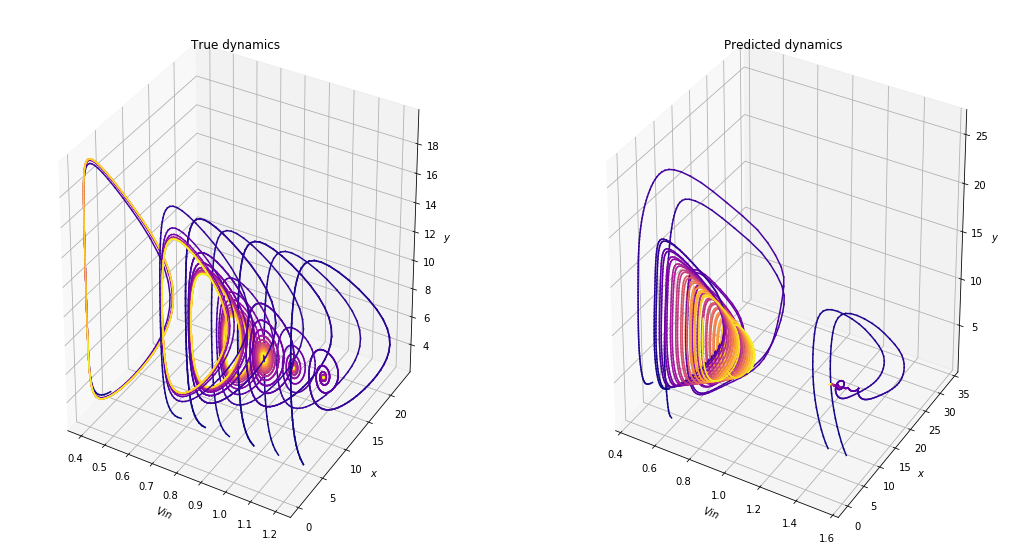

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18,10)) # twice as wide as it is tall
ax = fig.add_subplot(1, 2, 1, projection='3d')

for j in range(0, hopf_data.shape[0]):
    mu = hopf_data[j, :, 0]
    x = hopf_data[j, :, 1]
    y = hopf_data[j, :, 2]
    
    for i in range(0, len(x)):
        ax.plot(mu[i:i+2], x[i:i+2], y[i:i+2], color=plt.cm.plasma(int(255*i/len(x))))

ax.set_xlabel('$Vin$')
ax.set_ylabel('$x$')
ax.set_zlabel('$y$')
ax.set_title('True dynamics', fontsize = 12, loc='center', pad=2.0)

ax = fig.add_subplot(1, 2, 2, projection='3d')
for j in range(0, hopf_pred.shape[0]):
    mu = hopf_pred[j, :, 0]
    x = hopf_pred[j, :, 1]
    y = hopf_pred[j, :, 2]
    
    for i in range(0, len(x)):
        ax.plot(mu[i:i+2], x[i:i+2], y[i:i+2], color=plt.cm.plasma(int(255*i/len(x))))

ax.set_xlabel('$Vin$')
ax.set_ylabel('$x$')
ax.set_zlabel('$y$')
ax.set_title('Predicted dynamics', fontsize = 12, loc='center', pad=2.0)

plt.show()

In [2]:
!pip install --user nodepy

     |████████████████████████████████| 819kB 3.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install --user --upgrade tensorflow

     |████████████████████████████████| 516.2MB 10kB/s  eta 0:00:011  |                                | 307kB 3.1MB/s eta 0:02:45     |████████▊                       | 140.9MB 55.7MB/s eta 0:00:07��█████████████████████████▌  | 475.0MB 60.1MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 36.1MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 39.9MB/s eta 0:00:01
     |████████████████████████████████| 460kB 29.9MB/s eta 0:00:01
     |████████████████████████████████| 778kB 29.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1a/70/1935c770cb3be6e3a8b78ced23d7e0f3b187f5cbfab4749523ed65d7c9b1/requests-2.23.0-py2.py3-none-any.whl
     |████████████████████████████████| 92kB 2.9MB/s  eta 0:00:01
     |████████████████████████████████| 163kB 46.1MB/s eta 0:00:01
     |████████████████████████████████| 153kB 50.1MB/s eta 0:00:01
ERROR: tensorflow-serving-api 1.15.0 has requirement tensorflow~=1.15.0, but you'll have tensorflow 2.2.0 which is

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.
